#Install, imports and basic code run

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.10.1
!pip install tensorflow-addons
!pip install wandb
!pip install scikit-fuzzy

In [ ]:
import io
import imageio
import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
import wandb
from wandb.keras import WandbCallback


import PIL
from IPython import display
from tqdm.notebook import tqdm_notebook
import random
from tensorflow.keras import layers, Model, Input
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
# from keras_preprocessing.image import img_to_array, load_img

# Setting seed for reproducibility
SEED = 42

os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ['PYTHONHASHSEED']='0'
tf.keras.utils.set_random_seed(SEED)
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.callbacks import EarlyStopping

# import tensorflow_addons as tfa
from tensorflow.keras.layers import Concatenate, Conv2D, Conv3D, Layer, Dense, Attention, GlobalAveragePooling2D, Lambda,\
 Flatten, Reshape, AveragePooling2D, Add, LSTM, Multiply, Softmax, Dropout, LeakyReLU, GRU, TimeDistributed

from keras.losses import binary_crossentropy
import keras.backend as K
from tensorflow.keras.layers import Layer, Input, Concatenate, Conv3D, Add, Dense, Lambda, Activation, Multiply, RepeatVector, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.activations import sigmoid
import tensorflow. keras.backend as K

In [ ]:
%cd '/content/drive/MyDrive/obj4'
import sys
from sf_gru_o import SFGRU
sys.path.insert(0,'/content/drive/MyDrive/datasets/PIE')
from pie_data import PIE

data_opts ={'fstride': 1,
            'subset': 'default',
            'data_split_type': 'random',  # kfold, random, default
            'seq_type': 'trajectory',
            'min_track_size': 61} ## for obs length of 15 frames + 60 frames tte. This should be adjusted for different setup
imdb = PIE(data_path='/content/drive/MyDrive/datasets/PIE') # change with the path to the dataset

beh_seq_train = imdb.generate_data_trajectory_sequence('train', **data_opts)
beh_seq_val = imdb.generate_data_trajectory_sequence('val', **data_opts)
beh_seq_test = imdb.generate_data_trajectory_sequence('test', **data_opts)


In [ ]:
def convert_normalize_bboxes(all_bboxes, normalize, bbox_type):
    '''input box type is x1y1x2y2 in original resolution'''
    for i in range(len(all_bboxes)):
        if len(all_bboxes[i]) == 0:
            continue
        bbox = np.array(all_bboxes[i])
        # NOTE ltrb to cxcywh
        if bbox_type == 'cxcywh':
            bbox[..., [2, 3]] = bbox[..., [2, 3]] - bbox[..., [0, 1]]
            bbox[..., [0, 1]] += bbox[..., [2, 3]]/2
        # NOTE Normalize bbox
        if normalize == 'zero-one':
            # W, H  = all_resolutions[i][0]
            _min = np.array(self.args.min_bbox)[None, :]
            _max = np.array(self.args.max_bbox)[None, :]
            bbox = (bbox - _min) / (_max - _min)
        elif normalize == 'plus-minus-one':
            # W, H  = all_resolutions[i][0]
            _min = np.array(self.args.min_bbox)[None, :]
            _max = np.array(self.args.max_bbox)[None, :]
            bbox = (2 * (bbox - _min) / (_max - _min)) - 1
        elif normalize == 'none':
            pass
        else:
            raise ValueError(normalize)
        all_bboxes[i] = bbox
    return all_bboxes

In [ ]:
def get_traj_tracks(dataset, data_types, observe_length, predict_length, overlap, normalize):
        """
        Generates tracks by sampling from pedestrian sequences
        :param dataset: The raw data passed to the method
        :param data_types: Specification of types of data for encoder and decoder. Data types depend on datasets. e.g.
        JAAD has 'bbox', 'ceneter' and PIE in addition has 'obd_speed', 'heading_angle', etc.
        :param observe_length: The length of the observation (i.e. time steps of the encoder)
        :param predict_length: The length of the prediction (i.e. time steps of the decoder)
        :param overlap: How much the sampled tracks should overlap. A value between [0,1) should be selected
        :param normalize: Whether to normalize center/bounding box coordinates, i.e. convert to velocities. NOTE: when
        the tracks are normalized, observation length becomes 1 step shorter, i.e. first step is removed.
        :return: A dictinary containing sampled tracks for each data modality
        """
        #  Calculates the overlap in terms of number of frames
        seq_length = observe_length + predict_length
        overlap_stride = observe_length if overlap == 0 else \
            int((1 - overlap) * observe_length)
        overlap_stride = 1 if overlap_stride < 1 else overlap_stride

        #  Check the validity of keys selected by user as data type
        d = {}
        for dt in data_types:
            try:
                d[dt] = dataset[dt]
            except:# KeyError:
                raise KeyError('Wrong data type is selected %s' % dt)

        d['image'] = dataset['image']
        d['pid'] = dataset['pid']
        # d['resolution'] = dataset['resolution']
        # d['flow'] = []
        num_trks = len(d['image'])
        #  Sample tracks from sequneces
        for k in d.keys():
            tracks = []
            for track in d[k]:
                for i in range(0, len(track) - seq_length + 1, overlap_stride):
                    tracks.append(track[i:i + seq_length])
            d[k] = tracks
        #  Normalize tracks using FOL paper method,
        d['bbox'] = convert_normalize_bboxes(d['bbox'],'none', 'ltrb')
        return d

def get_traj_data(data, **model_opts):
    """
    Main data generation function for training/testing
    :param data: The raw data
    :param model_opts: Control parameters for data generation characteristics (see below for default values)
    :return: A dictionary containing training and testing data
    """

    opts = {
        'normalize_bbox': True,
        'track_overlap': 0.5,
        'observe_length': 15,
        'predict_length': 45,
        'enc_input_type': ['bbox'],
        'dec_input_type': [],
        'prediction_type': ['bbox']
    }
    for key, value in model_opts.items():
        assert key in opts.keys(), 'wrong data parameter %s' % key
        opts[key] = value

    observe_length = opts['observe_length']
    data_types = set(opts['enc_input_type'] + opts['dec_input_type'] + opts['prediction_type'])
    data_tracks = get_traj_tracks(data, data_types, observe_length,
                                  opts['predict_length'], opts['track_overlap'],
                                  opts['normalize_bbox'])
    obs_slices = {}
    pred_slices = {}
    #  Generate observation/prediction sequences from the tracks
    for k in data_tracks.keys():
        obs_slices[k] = []
        pred_slices[k] = []
        # NOTE: Add downsample function
        down = 1
        obs_slices[k].extend([d[down-1:observe_length:down] for d in data_tracks[k]])
        pred_slices[k].extend([d[observe_length+down-1::down] for d in data_tracks[k]])

    ret =  {'obs_image': obs_slices['image'],
            'obs_pid': obs_slices['pid'],

            'pred_image': pred_slices['image'],
            'pred_pid': pred_slices['pid'],


            'obs_bbox': np.array(obs_slices['bbox']), #enc_input,

            'pred_bbox': np.array(pred_slices['bbox']), #pred_target,
            }

    return ret

In [ ]:
import numpy as np
traj_model_opts = {'normalize_bbox': True,
              'track_overlap': 0.5,
              'observe_length': 15,
              'predict_length': 45,
              'enc_input_type': ['bbox'],
              'dec_input_type': [],
              'prediction_type': ['bbox']
              }

traj_model_opts['enc_input_type'].extend(['obd_speed', 'heading_angle'])
traj_model_opts['prediction_type'].extend(['obd_speed', 'heading_angle'])

train_data = get_traj_data(beh_seq_train, **traj_model_opts)
val_data = get_traj_data(beh_seq_val, **traj_model_opts)
test_data = get_traj_data(beh_seq_test, **traj_model_opts)

In [ ]:

def squarify(bbox, squarify_ratio, img_width):
	"""
	Changes is the ratio of bounding boxes to a fixed ratio
	:param bbox: Bounding box
	:param squarify_ratio: Ratio to be changed to
	:param img_width: Image width
	:return: Squarified boduning box
	"""
	width = abs(bbox[0] - bbox[2])
	height = abs(bbox[1] - bbox[3])
	width_change = height * squarify_ratio - width
	bbox[0] = bbox[0] - width_change/2
	bbox[2] = bbox[2] + width_change/2
	# Squarify is applied to bounding boxes in Matlab coordinate starting from 1
	if bbox[0] < 0:
		bbox[0] = 0

	# check whether the new bounding box goes beyond image boarders
	# If this is the case, the bounding box is shifted back
	if bbox[2] > img_width:
		# bbox[1] = str(-float(bbox[3]) + img_dimensions[0])
		bbox[0] = bbox[0]-bbox[2] + img_width
		bbox[2] = img_width
	return bbox

In [ ]:
def bbox_sanity_check(img_size, bbox):
	"""
	Confirms that the bounding boxes are within image boundaries.
	If this is not the case, modifications is applied.
	:param img_size: The size of the image
	:param bbox: The bounding box coordinates
	:return: The modified/original bbox
	"""
	img_width, img_heigth = img_size
	if bbox[0] < 0:
		bbox[0] = 0.0
	if bbox[1] < 0:
		bbox[1] = 0.0
	if bbox[2] >= img_width:
		bbox[2] = img_width - 1
	if bbox[3] >= img_heigth:
		bbox[3] = img_heigth - 1
	return bbox


In [ ]:

def jitter_bbox(img_path, bbox, mode, ratio):
	"""
	This method jitters the position or dimensions of the bounding box.
	:param img_path: The to the image
	:param bbox: The bounding box to be jittered
	:param mode: The mode of jittere:
	'same' returns the bounding box unchanged
		  'enlarge' increases the size of bounding box based on the given ratio.
		  'random_enlarge' increases the size of bounding box by randomly sampling a value in [0,ratio)
		  'move' moves the center of the bounding box in each direction based on the given ratio
		  'random_move' moves the center of the bounding box in each direction by randomly
						sampling a value in [-ratio,ratio)
	:param ratio: The ratio of change relative to the size of the bounding box.
		   For modes 'enlarge' and 'random_enlarge'
		   the absolute value is considered.
	:return: Jittered bounding box
	"""

	assert(mode in ['same','enlarge','move','random_enlarge','random_move']), \
			'mode %s is invalid.' % mode

	if mode == 'same':
		return bbox

	img = load_img(img_path)

	if mode in ['random_enlarge', 'enlarge']:
		jitter_ratio  = abs(ratio)
	else:
		jitter_ratio  = ratio

	if mode == 'random_enlarge':
		jitter_ratio = np.random.random_sample()*jitter_ratio
	elif mode == 'random_move':
		# for ratio between (-jitter_ratio, jitter_ratio)
		# for sampling the formula is [a,b), b > a,
		# random_sample * (b-a) + a
		jitter_ratio = np.random.random_sample() * jitter_ratio * 2 - jitter_ratio

	jit_boxes = []
	for b in bbox:
		bbox_width = b[2] - b[0]
		bbox_height = b[3] - b[1]

		width_change = bbox_width * jitter_ratio
		height_change = bbox_height * jitter_ratio

		if width_change < height_change:
			height_change = width_change
		else:
			width_change = height_change

		if mode in ['enlarge','random_enlarge']:
			b[0] = b[0] - width_change //2
			b[1] = b[1] - height_change //2
		else:
			b[0] = b[0] + width_change //2
			b[1] = b[1] + height_change //2

		b[2] = b[2] + width_change //2
		b[3] = b[3] + height_change //2

		# Checks to make sure the bbox is not exiting the image boundaries
		b = bbox_sanity_check(img.size, b)
		jit_boxes.append(b)
	# elif crop_opts['mode'] == 'border_only':
	return jit_boxes

In [ ]:
def img_pad(img, mode = 'warp', size = 224):
	"""
	Pads a image given the boundries of the box needed
	:param img: The image to be coropped and/or padded
	:param mode: The type of padding or resizing:
			warp: crops the bounding box and resize to the output size
			same: only crops the image
			pad_same: maintains the original size of the cropped box  and pads with zeros
			pad_resize: crops the image and resize the cropped box in a way that the longer edge is equal to
						the desired output size in that direction while maintaining the aspect ratio. The rest
						of the image is	padded with zeros
			pad_fit: maintains the original size of the cropped box unless the image is bigger than the size
					in which case it scales the image down, and then pads it
	:param size: Target size of image
	:return:
	"""
	assert(mode in ['same', 'warp', 'pad_same', 'pad_resize', 'pad_fit']), 'Pad mode %s is invalid' % mode
	image = img.copy()
	if mode == 'warp':
		warped_image = image.resize((size,size), PIL.Image.NEAREST)
		return warped_image
	elif mode == 'same':
		return image
	elif mode in ['pad_same', 'pad_resize', 'pad_fit']:
		img_size = image.size  # size is in (width, height)
		ratio = float(size)/max(img_size)
		if mode == 'pad_resize' or	\
			(mode == 'pad_fit' and (img_size[0] > size or img_size[1] > size)):
			img_size = tuple([int(img_size[0]*ratio),int(img_size[1]*ratio)])
			image = image.resize(img_size, PIL.Image.NEAREST)
		padded_image = PIL.Image.new("RGB", (size, size))
		padded_image.paste(image, ((size-img_size [0])//2,
					(size-img_size [1])//2))
		return padded_image



#Custom Data Generator

In [ ]:
#Custom Data Generator
save_path1 = '/content/drive/MyDrive/obj4/features'
save_path2 = '/content/drive/MyDrive/obj4/seg_features'
convnet = tf.keras.applications.efficientnet.EfficientNetB4(input_shape=(224, 224, 3),
                              include_top=False, weights='imagenet')


import tensorflow as tf
import PIL

import random
import numpy as np
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self,x,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True, train=1):


        self.x=x

        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.train= train
        self.n = len(self.x[0])

    def on_epoch_end(self):
        if self.shuffle:
            ind = np.random.randint(0, len(self.x[0]), len(self.x[0]))
            self.x[0] = self.x[0][ind]
            self.x[1] = self.x[1][ind]
            self.x[2] = self.x[2][ind]




    def __get_input(self, path_batch, bbox, target_size, seg=0):


      if seg==0:
        img_seq=[]
        for path,b in zip(path_batch,bbox):
           set_id = path.split('/')[-3]
           vid_id = path.split('/')[-2]
           img_name = path.split('/')[-1].split('.')[0]

           img_save_folder = os.path.join(save_path1, set_id, vid_id)
           img_save_path = os.path.join(img_save_folder, img_name + '.pkl')


           flip_image=False
           if 'flip' in path:
                        path = path.replace('_flip', '')

                        flip_image = True

           img= tf.keras.preprocessing.image.load_img(path)

           if flip_image:
              img = img.transpose(Image.FLIP_LEFT_RIGHT)

           box = list(map(int, b[0:4]))
          #  box = jitter_bbox(path, [box], 'enlarge', 1)[0]

           box = squarify(box, 1, img.size[0])
           cropped_image = img.crop(box)
           img_data = img_pad(cropped_image, mode='pad_resize', size=224)

           image_array = tf.keras.preprocessing.image.img_to_array(img_data)
           preprocessed_img = tf.keras.applications.efficientnet.preprocess_input(image_array)
           expanded_img = np.expand_dims(preprocessed_img, axis=0)
           img_features = convnet.predict(expanded_img, verbose=0)

           img_features = np.squeeze(img_features)

           img_features = np.average(img_features, axis=0)

           img_features = np.average(img_features, axis=0)
           if not os.path.exists(img_save_folder):
              os.makedirs(save_path1)
           with open(img_save_path, 'wb') as fid:
                        pickle.dump(img_features, fid, pickle.HIGHEST_PROTOCOL)
           img_seq.append(img_features)



      elif seg==1:
        img_seq=[]
        for path,b in zip(path_batch,bbox):
           path = path.replace('images','seg_images')

           flip_image=False
           if 'flip' in path:
                        path = path.replace('_flip', '')

                        flip_image = True
           img= tf.keras.preprocessing.image.load_img(path)

           if flip_image:
              img = img.transpose(Image.FLIP_LEFT_RIGHT)
          #  box = list(map(int, b[0:4]))
          #  box = jitter_bbox(path, [box], 'enlarge', 5)[0]
          #  box = squarify(box, 1, img.size[0])

          #  cropped_image = img.crop(box)
          #  img_data = img_pad(cropped_image, mode='pad_resize', size=224)
           img_data = img_pad(img, mode='warp', size=224)

          #  cropped_image = img.crop(list(map(int, b[0:4])))
          #  img_data = cropped_image.resize((224,224), PIL.Image.NEAREST)

           img_seq.append(img_to_array(img_data)/255)

      else:
          box_seq = []

            # Calculate minimum and maximum values

          x_max = 1920
          y_max = 1080


            # Normalize the bounding box sequence
          for b in bbox:

              x_bleft, y_bleft, x_tright, y_tright = b
              xbl_normalized = (x_bleft) / (x_max)
              ybl_normalized = (y_bleft) / (y_max)
              xtr_normalized = (x_tright) / (x_max)
              ytr_normalized = (y_tright) / (y_max)



              normalized_b = (
                  xbl_normalized,
                  ybl_normalized,
                  xtr_normalized,
                  ytr_normalized
              )


              box_seq.append(normalized_b)

          img_seq=[]
          for b in bbox:
            x_centre = (b[0] + b[2])/2
            y_centre = (b[1] + b[3])/2
            width = np.abs(b[0] - b[2])
            height = np.abs(b[1] - b[3])
            b = (x_centre, y_centre, width, height)
            img_seq.append(b)



      return img_seq


    def __get_data(self, batches_b, batches_p, batches_i):
        # # Generates data containing batch_size samples


        bbox_batch = batches_b
        pred_batch = batches_p
        image_batch = batches_i
        x_im_bat=[]
        x_seg_bat=[]
        x_bbox_bat=[]
        x_pred_bat=[]

        for i,j in zip(image_batch, bbox_batch):

          # update_progress(p / len(image_batch))
          x_bbox_bat.append(self.__get_input(i, j, self.input_size, seg=2))
        X_bbox_batch =np.asarray(x_bbox_bat)

        # X_batch = np.asarray([self.__get_input(i, j, self.input_size) for i, j in zip(image_batch, bbox_batch)])


        for i,j in zip(image_batch, pred_batch):

          # update_progress(p / len(image_batch))
          x_pred_bat.append(self.__get_input(i, j, self.input_size, seg=2))
        X_pred_batch =np.asarray(x_pred_bat)

        for i,j in zip(image_batch, bbox_batch):

          inp = self.__get_input(i, j, self.input_size, seg=0)
          x_im_bat.append(inp)

        X_batch =np.asarray(x_im_bat)

        for i,j in zip(image_batch, bbox_batch):
          inp = self.__get_input(i, j, self.input_size, seg=1)
          x_seg_bat.append(self.__get_input(i, j, self.input_size, seg=1))
        X_seg_batch =np.asarray(x_seg_bat)
        # X_batch = np.asarray([self.__get_input(i, j, self.input_size) for i, j in zip(image_batch, bbox_batch)])


        return X_bbox_batch, X_pred_batch, X_batch, X_seg_batch

    def __getitem__(self, index):


        batches_obs = self.x[0][index * self.batch_size:(index + 1) * self.batch_size]
        batches_pred =  self.x[1][index * self.batch_size:(index + 1) * self.batch_size]
        batches_im = self.x[2][index * self.batch_size:(index + 1) * self.batch_size]

        X_obs_box, X_pred_box, X, X_seg = self.__get_data(batches_obs, batches_pred, batches_im)


        return [tf.convert_to_tensor(X_obs_box), tf.convert_to_tensor(X_pred_box), tf.convert_to_tensor(X), tf.convert_to_tensor(X_seg) ], tf.convert_to_tensor(X_pred_box)
    def __len__(self):
        return self.n // self.batch_size


In [ ]:
BATCH_SIZE=8
x_train = [train_data['obs_bbox'], train_data['pred_bbox'], train_data['obs_image']]
x_val = [val_data['obs_bbox'], val_data['pred_bbox'], val_data['obs_image']]
x_test = [test_data['obs_bbox'], test_data['pred_bbox'], test_data['obs_image']]
traingen = CustomDataGen([x_train[0], x_train[1]],batch_size=BATCH_SIZE)
valgen = CustomDataGen([x_val[0], x_val[1]],batch_size=BATCH_SIZE)
testgen = CustomDataGen([x_test[0], x_test[1]], batch_size=BATCH_SIZE)

# Model Architecture

In [ ]:
#Progression Parameters
class Alpha_Scale(Layer):
    def __init__(self, use_alpha=True, **kwargs):
        self.use_alpha = use_alpha
        super(Alpha_Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.alpha = self.add_weight(
                shape=(),
                initializer='zeros',  # You can use 'zeros' for initialization
                trainable=True,
                name='alpha',
            )
        super(Alpha_Scale, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        if self.use_alpha:
            scaled_inputs = self.alpha * inputs
        else:
            one_minus_alpha = 1.0 - self.alpha
            scaled_inputs = one_minus_alpha * inputs
        return scaled_inputs

class Beta_Scale(Layer):
    def __init__(self, use_alpha=True, **kwargs):
        self.use_alpha = use_alpha
        super(Beta_Scale, self).__init__(**kwargs)

    def build(self, input_shape):

        self.alpha = self.add_weight(
                shape=(),
                initializer='zeros',  # You can use 'zeros' for initialization
                trainable=True,
                name='beta',
            )
        super(Beta_Scale, self).build(input_shape)

    def call(self, inputs):
        if self.use_alpha:
            scaled_inputs = self.alpha * inputs
        else:
            one_minus_alpha = 1.0 - self.alpha
            scaled_inputs = one_minus_alpha * inputs
        return scaled_inputs

class Gamma_Scale(Layer):
    def __init__(self, use_alpha=True, **kwargs):
        self.use_alpha = use_alpha
        super(Gamma_Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.alpha = self.add_weight(
                shape=(),
                initializer='zeros',  # You can use 'zeros' for initialization
                trainable=True,
                name='gamma',
            )
        super(Gamma_Scale, self).build(input_shape)

    def call(self, inputs):
        if self.use_alpha:
            scaled_inputs = self.alpha * inputs
        else:
            one_minus_alpha = 1.0 - self.alpha
            scaled_inputs = one_minus_alpha * inputs
        return scaled_inputs

class Delta_Scale(Layer):
    def __init__(self, use_alpha=True, **kwargs):
        self.use_alpha = use_alpha
        super(Delta_Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.alpha = self.add_weight(
                shape=(),
                initializer='zeros',  # You can use 'zeros' for initialization
                trainable=True,
                name='delta',
            )
        super(Delta_Scale, self).build(input_shape)

    def call(self, inputs):
        if self.use_alpha:
            scaled_inputs = self.alpha * inputs
        else:
            one_minus_alpha = 1.0 - self.alpha
            scaled_inputs = one_minus_alpha * inputs
        return scaled_inputs



In [ ]:
# Define the dimensions of your input and output sequences
input_seq_length = 15
output_seq_length = 45
input_dim = 4
hidden_units = 64  # Number of LSTM units in the encoder and decoder

# Define the input layers
box_input = Input(shape=(input_seq_length, input_dim))
rgb_input = Input(shape=(15, 1792))
segmentation_input = Input(shape=(15, 7, 7, 1792))
encoder_inputs = [box_input, rgb_input, segmentation_input]
decoder_inputs = Input(shape=(output_seq_length, input_dim))

gating_factor = tf.Variable(initial_value=np.float32(0.7), trainable=True, dtype=tf.float32)
scale_alpha = Alpha_Scale(use_alpha=True)
scale_minus_alpha = Alpha_Scale(use_alpha=False)
scale_beta = Beta_Scale(use_alpha=True)
scale_minus_beta = Beta_Scale(use_alpha=False)
scale_gamma = Gamma_Scale(use_alpha=True)
scale_minus_gamma = Gamma_Scale(use_alpha=False)
scale_delta = Delta_Scale(use_alpha=True)
scale_minus_delta = Delta_Scale(use_alpha=False)

# Define the encoder LSTM
encoder_op1, state_h1, state_c1 = LSTM(hidden_units, return_sequences=True, return_state=True)(encoder_inputs)
scaled_enc_op1 = scale_alpha(encoder_op1)

encoder_op2, state_h2, state_c2 = LSTM(hidden_units, return_sequences=True, return_state=True)(scaled_enc_op1)
scaled_enc_op2 = Add()([scale_beta(encoder_op2), scale_minus_alpha(encoder_op1)])

encoder_op3, state_h3, state_c3 = LSTM(hidden_units, return_sequences=True, return_state=True)(scaled_enc_op2)

final_output_1 = Add()([encoder_op3, scale_minus_beta(encoder_op2)])
final_output_2 = Add()([final_output_1, scale_minus_alpha(encoder_op1)])


# Define the decoder LSTM
decoder_lstm1 = LSTM(hidden_units, return_sequences=True, return_state=True)
dec_state_h3, dec_state_c3 = state_h3, state_c3  # Initialize decoder state with encoder state
initial_teacher_forcing_rate = 1.0
teacher_forcing_decay_steps = 10000
gating_layer = tf.keras.layers.Dense(1, activation='sigmoid')
gating_input = gating_layer(dec_state_h3)
use_teacher_forcing = tf.random.uniform(shape=(1,)) < gating_factor
current_teacher_forcing_rate = initial_teacher_forcing_rate * min(1.0, 200000 / teacher_forcing_decay_steps)
# Initialize an empty list to store decoder outputs
all_decoder_outputs = []

# Iterate through the decoder timesteps
for timestep in range(output_seq_length):

    if timestep==0:
      context_vector= dec_state_h3


    # Apply the decoder LSTM for the current timestep
    attention_scores = Dot(axes=[2, 1])([final_output_2, context_vector])
    # The above line calculates dot products correctly.

    # Apply softmax to get attention weights
    attention_weights = tf.keras.layers.Softmax()(attention_scores)

    # Calculate the context vector
    context_vector = tf.reduce_sum(tf.expand_dims(attention_weights, axis=-1) * final_output_2, axis=1)

    # context_vector =  tf.squeeze(context_vector, axis=1)
    if timestep==0:
      decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm1(decoder_inputs[:, 0:1, :], initial_state=[context_vector, dec_state_c3])
      decoder_prev = decoder_outputs
    else:
      if use_teacher_forcing:
          decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm1(decoder_inputs[:, timestep-1:timestep, :], initial_state=[context_vector, dec_state_c3])
          decoder_prev = decoder_outputs
      else:

          decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm1(decoder_prev[:, timestep-1:timestep, :], initial_state=[context_vector, dec_state_c3])
          decoder_prev = decoder_outputs
    # Append the decoder output to the list
    all_decoder_outputs.append(decoder_outputs)

# Stack the decoder outputs and reshape to (batch_size, output_seq_length, hidden_units)
decoder_op1 = tf.squeeze(tf.stack(all_decoder_outputs, axis=1), axis=2)

scaled_op1 = scale_gamma(decoder_op1)
decoder_op2, dec_state_h2, dec_state_c2 = LSTM(hidden_units, return_sequences=True, return_state=True)(scaled_op1)
scaled_op2 = Add()([scale_delta(decoder_op2), scale_minus_gamma(decoder_op1)])

decoder_op3, state_h, state_c = LSTM(hidden_units, return_sequences=True, return_state=True)(scaled_op2)

final_output_1 = Add()([decoder_op3, scale_minus_delta(decoder_op2)])
final_output_2 = Add()([final_output_1, scale_minus_gamma(decoder_op1)])


# Define the output layer
output_layer = Dense(input_dim)

# Apply the output layer to the decoder outputs
decoder_out = output_layer(final_output_2)

# Create the Seq2Seq model
Generator = Model([encoder_inputs, decoder_inputs], decoder_out)
Generator.summary()

In [ ]:
#Normalization of coordiantes
def rev_norm(traj):
    traj = tf.cast(traj, dtype=tf.float32) * tf.constant([1920, 1080, 1920, 1080], dtype=tf.float32)
    return traj

disc_learning_rate = 1e-6
gen_learning_rate = 1e-6

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate)
disc_optimizer = tf.keras.optimizers.RMSprop(learning_rate=disc_learning_rate)


In [ ]:
# Step 1: Discriminator Setup
discriminator_inputs = Input(shape=(45, 4))
lstm_out, h_state, c_state = LSTM(100, return_sequences=False, return_state=True, activation='relu')(discriminator_inputs)
# Dense layer for binary classification
bin = Dense(2, activation=None)(h_state)


In [ ]:
class TriangularMembershipFunction_real(tf.Module):
    def __init__(self, initial_peak, initial_left_boundary, initial_right_boundary):
        self.peak = tf.Variable(initial_peak, dtype=tf.float32, trainable=True)
        self.left_boundary = tf.Variable(initial_left_boundary, dtype=tf.float32, trainable=True)
        self.right_boundary = tf.Variable(initial_right_boundary, dtype=tf.float32, trainable=True)

        # Enforce peak constraints
        # self.peak = tf.clip_by_value(self.peak, 0.6, 1.0)  # Adjust the range as needed

    def __call__(self, x):
        condition1 = tf.logical_and(tf.greater_equal(x, self.left_boundary), tf.less(x, self.peak))
        condition2 = tf.logical_and(tf.greater_equal(x, self.peak), tf.less(x, self.right_boundary))

        term1 = tf.where(condition1, (x - self.left_boundary) / (self.peak - self.left_boundary), 0.0)
        term2 = tf.where(condition2, (self.right_boundary - x) / (self.right_boundary - self.peak), 0.0)

        return term1 + term2

class TriangularMembershipFunction_fake(tf.Module):
    def __init__(self, initial_peak, initial_left_boundary, initial_right_boundary):
        self.peak = tf.Variable(initial_peak, dtype=tf.float32, trainable=True)
        self.left_boundary = tf.Variable(initial_left_boundary, dtype=tf.float32, trainable=True)
        self.right_boundary = tf.Variable(initial_right_boundary, dtype=tf.float32, trainable=True)

        # Enforce peak constraints
        # self.peak = tf.clip_by_value(self.peak, 0, 0.4)  # Adjust the range as needed

    def __call__(self, x):
        condition1 = tf.logical_and(tf.greater_equal(x, self.left_boundary), tf.less(x, self.peak))
        condition2 = tf.logical_and(tf.greater_equal(x, self.peak), tf.less(x, self.right_boundary))

        term1 = tf.where(condition1, (x - self.left_boundary) / (self.peak - self.left_boundary), 0.0)
        term2 = tf.where(condition2, (self.right_boundary - x) / (self.right_boundary - self.peak), 0.0)

        return term1 + term2
triangular_membership_real = TriangularMembershipFunction_real(initial_peak=0.5, initial_left_boundary=0, initial_right_boundary=1)
triangular_membership_fake = TriangularMembershipFunction_fake(initial_peak=0.5, initial_left_boundary=0, initial_right_boundary=1)

In [ ]:
# Define a custom layer for fuzzy inference
class FuzzyInferenceLayer(Layer):
    def __init__(self, **kwargs):
        super(FuzzyInferenceLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(FuzzyInferenceLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        # real_membership = triangular_membership_real(x, 0.3, 0.5, 0.7)
        # fake_membership = triangular_membership_fake(x, 0.3, 0.5, 0.7)
        real_membership = triangular_membership_real(x)
        fake_membership = triangular_membership_fake(x)
        # Apply fuzzy inference rules (in this case, we'll use the max operator)
        # fuzzy_decision = tf.reduce_max([real_membership, fake_membership], axis=0)
        fuzzy_decision = tf.reduce_max([real_membership, fake_membership], axis=0)


        # Implement the fuzzy rule
        condition = tf.math.argmax([real_membership, fake_membership], axis=0)

        # If fake_membership has the higher value, take the complement
        fuzzy_decision = tf.where(condition == 1, 1.0 - fake_membership, fuzzy_decision)
        return fuzzy_decision

# Apply fuzzy inference using the custom layer
fuzzy_decision = FuzzyInferenceLayer()(bin)
Discriminator = Model(inputs=discriminator_inputs, outputs=fuzzy_decision)
Discriminator.summary()

#Losses & Metrics

In [ ]:
class MSE2Metric(tf.keras.metrics.Metric):
    def __init__(self, name="mse2", **kwargs):
        super(MSE2Metric, self).__init__(name=name, **kwargs)
        self.mse = self.add_weight(name="mse", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        squared_error = tf.square(y_true - y_pred)

        self.mse.assign_add(tf.reduce_sum(squared_error))
        self.total_samples.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.mse, self.total_samples)

    def reset_states(self):
        self.mse.assign(0.0)
        self.total_samples.assign(0.0)
mse2 = MSE2Metric()

In [ ]:
class MSECenter(tf.keras.metrics.Metric):
    def __init__(self, name='mse_center', **kwargs):
        super(MSECenter, self).__init__(name=name, **kwargs)
        self.cmse = self.add_weight(name='cmse', initializer='zeros')
        self.num_batches = self.add_weight(name="num_batches", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_true_center_x = (y_true[:, 0] + y_true[:, 2]) / 2.0
        y_true_center_y = (y_true[:, 1] + y_true[:, 3]) / 2.0

        y_pred_center_x = (y_pred[:, 0] + y_pred[:, 2]) / 2.0
        y_pred_center_y = (y_pred[:, 1] + y_pred[:, 3]) / 2.0

        mse_x = tf.reduce_mean(tf.square(y_true_center_x - y_pred_center_x))
        mse_y = tf.reduce_mean(tf.square(y_true_center_y - y_pred_center_y))

        # Accumulate CMSE for each batch
        self.cmse.assign_add((mse_x + mse_y))
        self.num_batches.assign_add(1.0)

    def result(self):
        # Calculate the mean CMSE over all batches
        cmse = self.cmse / self.num_batches
        return cmse

    def reset_states(self):
        self.cmse.assign(0.0)
        self.num_batches.assign(0.0)

mse_center = MSECenter()


In [ ]:
class CFMSE(tf.keras.metrics.Metric):
    def __init__(self, name='cfmse', **kwargs):
        super(CFMSE, self).__init__(name=name, **kwargs)
        self.cfmse = self.add_weight(name='cfmse', initializer='zeros')
        self.num_batches = self.add_weight(name="num_batches", initializer="zeros")

    def update_state(self, y_true, y_pred):
        # Extract the last timestep values from y_true and y_pred
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_true_last_timestep = y_true[-1, :]
        y_pred_last_timestep = y_pred[-1, :]

        # Calculate the center points for the last timestep
        true_center_x = (y_true_last_timestep[0] + y_true_last_timestep[2]) / 2.0
        true_center_y = (y_true_last_timestep[1] + y_true_last_timestep[3]) / 2.0

        pred_center_x = (y_pred_last_timestep[0] + y_pred_last_timestep[2]) / 2.0
        pred_center_y = (y_pred_last_timestep[1] + y_pred_last_timestep[3]) / 2.0

        # Calculate the mean squared error between the center points for the last timestep
        mse_x = tf.reduce_mean(tf.square(true_center_x - pred_center_x))
        mse_y = tf.reduce_mean(tf.square(true_center_y - pred_center_y))

        # Increment num_batches only once for each batch update
        self.num_batches.assign_add(1.0)

        # Accumulate CFMSE for each batch
        self.cfmse.assign_add((mse_x + mse_y))

    def result(self):
        # Calculate the mean CFMSE over all batches
        cfmse = self.cfmse / self.num_batches
        return cfmse

    def reset_states(self):
        self.cfmse.assign(0.0)
        self.num_batches.assign(0.0)
cfmse = CFMSE()

In [ ]:
class DirectionalHuberLoss(tf.keras.losses.Loss):
    def __init__(self, delta=1.0, direction_loss_weight=0.5):
        super(DirectionalHuberLoss, self).__init__()
        self.delta = delta
        self.direction_loss_weight = direction_loss_weight

    def huber_loss(self, y_true, y_pred):
        # Huber loss implementation (as shown in previous code)

        error = y_true - y_pred
        absolute_error = K.abs(error)
        quadratic_error = 0.5 * K.square(error)
        huber_loss = K.switch(absolute_error < self.delta, quadratic_error, self.delta * (absolute_error - 0.5 * self.delta))
        return K.mean(huber_loss)

    def direction_loss(self, y_true, y_pred):
        # Normalize both predicted and ground truth vectors
        y_true = K.l2_normalize(y_true, axis=-1)
        y_pred = K.l2_normalize(y_pred, axis=-1)

        # Calculate cosine similarity
        cosine_similarity = K.sum(y_true * y_pred, axis=-1)

        # Directional loss: 1 - cosine_similarity to minimize the angle
        direction_loss = 1.0 - cosine_similarity

        return K.mean(direction_loss)

    def call(self, y_true, y_pred):
        huber_loss = self.huber_loss(y_true, y_pred)
        direction_loss = self.direction_loss(y_true, y_pred)

        # Combine the two losses with the specified weight
        loss = huber_loss + self.direction_loss_weight * direction_loss

        return loss


# Training

In [ ]:
#METHOD 5: Complete model with discriminator
class CustomModel(tf.keras.Model):
    def __init__(self, generator, discriminator, gen_optimizer, disc_optimizer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.dis_loss_tracker = tf.keras.metrics.Mean(name="dis_loss")
        self.mse2_metric = mse2
        self.mse_center = mse_center
        self.directional_loss = DirectionalHuberLoss()

        self.angle_tracker =tf.keras.metrics.Mean(name="a_loss")
        self.huber = tf.keras.losses.Huber()
        self.cfmse = cfmse

  # Modify your training function
    def train_step(self, data):
        x, y = data
        y = tf.squeeze(y)

        # Train discriminator
        with tf.GradientTape() as tape:
            fake_y = self.generator(x, training=True)
            real_output = self.discriminator(y, training=True)
            fake_output = self.discriminator(fake_y, training=True)


        # Fuzzify ground truth targets
            real_target = tf.ones_like(real_output)
            fake_target = tf.zeros_like(fake_output)

            # Calculate fuzzy discriminator loss
            disc_loss_real = tf.keras.losses.binary_crossentropy(real_output, real_target)
            disc_loss_fake = tf.keras.losses.binary_crossentropy(fake_output, fake_target)
            disc_loss = disc_loss_real + disc_loss_fake

        disc_gradients = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        # Train generator
        with tf.GradientTape() as tape:
            y_pred = self.generator(x, training=True)
            fake_output = self.discriminator(y_pred, training=True)
                      # Create a custom generator loss term
            gen_loss_mse = tf.keras.losses.binary_crossentropy(fake_output, real_target)  #
            gen_hub_loss = self.huber(rev_norm(y) , rev_norm(y_pred))
            gen_loss = gen_hub_loss+gen_loss_mse


        gen_gradients = tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        g_loss = gen_loss
        d_loss =disc_loss

        self.gen_loss_tracker.update_state(g_loss)
        self.dis_loss_tracker.update_state(d_loss)
        self.mse2_metric.reset_states()
        self.mse_center.reset_states()
        self.cfmse.reset_states()
        self.mse2_metric.update_state(rev_norm(y), rev_norm(y_pred))
        self.mse_center.update_state(rev_norm(y), rev_norm(y_pred))
        self.cfmse.update_state(rev_norm(y), rev_norm(y_pred))
        # self.angle_metric.update_state(tf.cast(y, tf.float32), tf.cast(y_pred, tf.float32))
        return {"g_loss": g_loss, "d_loss": d_loss, "MSE": self.mse2_metric.result(), "CMSE": self.mse_center.result(),  "CFMSE": self.cfmse.result()}


# Create instances of the generator and discriminator models
generator = Generator
discriminator = Discriminator

# Define optimizers for generator and discriminator
gen_optimizer = tf.keras.optimizers.Adam()
disc_optimizer = tf.keras.optimizers.Adam()
# Create an instance of the combined model
model = CustomModel(generator, discriminator, gen_optimizer, disc_optimizer, [encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam")
early_ck = tf.keras.callbacks.EarlyStopping(
    monitor="val_mse",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)
wandb.init(project="GAN-TRAJ")
wand = [WandbCallback()]
# Training loop using model.fit
epochs = 2

model.fit(traingen, epochs=epochs, validation_data = valgen)


In [ ]:
model.save('Path_to_save_the_model')

#Inference

In [ ]:
#Inference time computation
import time
start_time = time.time()
out_1 = generator([testgen[0][0][0],testgen[0][0][1]])
end_time = time.time()
inference_time = end_time - start_time

# Print the result and inference time
print(f"Inference Time: {inference_time:.6f} seconds")
# out_2 = generator([traingen[0][0][1],traingen[0][1]])

In [ ]:
concatenated_outputs = []

# Loop through traingen
for i in range(4426):
    # Generate output using the generator
    current_output = generator([testgen[i][0][0], testgen[i][0][1]])

    # Append the output to the list
    concatenated_outputs.append(current_output)


# Concatenate along the 0th dimension
out_variable = np.concatenate(concatenated_outputs, axis=0)
concatenated_outputs = []

# Loop through traingen
for i in range(4426):  # Since you mentioned i ranges from 0 to 5063
    # Generate output using the generator
    current_output = testgen[i][0][1]

    # Append the output to the list
    concatenated_outputs.append(current_output)

# Concatenate along the 0th dimension
in_variable = np.concatenate(concatenated_outputs, axis=0)

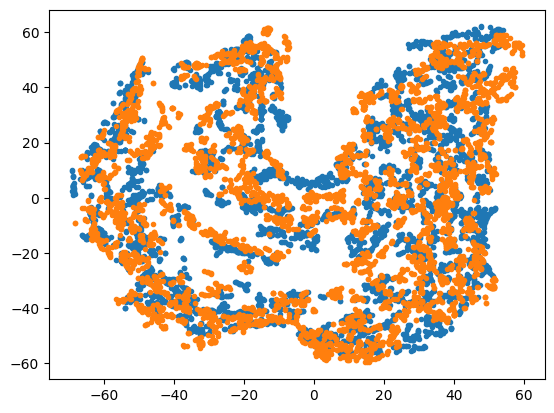

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'trajectory_data' is your entire dataset (N trajectories, each with shape (45, 4))
trajectory_data_in = in_variable  # Replace this with your actual data
trajectory_data_out = out_variable
# Subsample a portion of trajectories
subset_indices_i = np.random.choice(len(trajectory_data_in), size=5000, replace=False)
subset_trajectories_i = trajectory_data_in[subset_indices_i]

subset_indices_o = np.random.choice(len(trajectory_data_out), size=5000, replace=False)
subset_trajectories_o = trajectory_data_in[subset_indices_o]
# Flatten the trajectories to 2D for t-SNE
flattened_trajectories_i = subset_trajectories_i.reshape(len(subset_trajectories_i), -1)
flattened_trajectories_o = subset_trajectories_o.reshape(len(subset_trajectories_o), -1)
# Perform t-SNE
tsne_i = TSNE(n_components=2, perplexity=30, random_state=104)
embeddings_i = tsne_i.fit_transform(flattened_trajectories_i)
tsne_o = TSNE(n_components=2, perplexity=30, random_state=34)
embeddings_o = tsne_o.fit_transform(flattened_trajectories_o)
# Plot t-SNE results
plt.scatter(embeddings_i[:, 0], embeddings_i[:, 1], marker='.', label='gt')
plt.scatter(embeddings_o[:, 0], embeddings_o[:, 1], marker='.', label='pt')
# plt.legend()
# plt.title('t-SNE Visualization of Subset of Trajectories')
plt.show()

